<h1 align=center> Prétraitement et Stratégies de Modélisation </h1>

<h4>L'objectif de ce notebook est d'exploiter la structure du texte (au-delà de la sémantique) et de valider, par comparaison, l'efficacité d'une pondération différenciée des champs (Titre vs Description) par rapport à une fusion simple.</h4>

In [1]:
# ============================================================
# IMPORTS ET CHARGEMENT DES DONNÉES BRUTES
# ============================================================

import sys
sys.path.insert(0, "../src")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from rakuten_text.cleaning import global_text_cleaner
from rakuten_text.features import add_structural_features, get_meta_feature_columns
from rakuten_text.vectorization import (
    build_tfidf_title,
    build_tfidf_desc,
    build_tfidf_all,
    build_preprocess_split,
    build_preprocess_merged,
)
from rakuten_text.modeling import build_logreg_model, build_pipeline

import warnings
warnings.filterwarnings("ignore")

# Chargement des données brutes
print("Chargement des données brutes...")
X_raw = pd.read_csv("../data/X_train_update.csv", index_col=0)
Y_raw = pd.read_csv("../data/Y_train_CVw08PX.csv", index_col=0)

# Fusion sur productid
df_raw = X_raw.join(Y_raw, how="inner")
print(f"Données fusionnées : {df_raw.shape}")
print(f"Colonnes : {df_raw.columns.tolist()}")

Chargement des données brutes...
Données fusionnées : (84916, 5)
Colonnes : ['designation', 'description', 'productid', 'imageid', 'prdtypecode']


In [2]:
# ============================================================
# CONFIGURATIONS DE NETTOYAGE
# ============================================================

# Définition de trois variantes de nettoyage pour comparaison
CLEANING_CONFIGS = {
    "strong": {
        "use_basic_cleaning": True,
        "normalize_x_dimensions": True,
        "remove_boilerplate": True,
        "remove_nltk_stops": True,
        "remove_custom_stops": True,
        "remove_single_digit": True,
        "remove_single_letter": True,
    },
    "keep_digits": {
        "use_basic_cleaning": True,
        "normalize_x_dimensions": True,
        "remove_boilerplate": True,
        "remove_nltk_stops": True,
        "remove_custom_stops": True,
        "remove_single_digit": False,  # ← différence : on garde les chiffres isolés
        "remove_single_letter": True,
    },
    "keep_digits_letters": {
        "use_basic_cleaning": True,
        "normalize_x_dimensions": True,
        "remove_boilerplate": True,
        "remove_nltk_stops": True,
        "remove_custom_stops": True,
        "remove_single_digit": False,  # ← on garde les chiffres isolés
        "remove_single_letter": False, # ← on garde les lettres isolées
    },
}

print("Configurations de nettoyage définies :")
for name, config in CLEANING_CONFIGS.items():
    print(f"  - {name}: remove_single_digit={config['remove_single_digit']}, "
          f"remove_single_letter={config['remove_single_letter']}")

Configurations de nettoyage définies :
  - strong: remove_single_digit=True, remove_single_letter=True
  - keep_digits: remove_single_digit=False, remove_single_letter=True
  - keep_digits_letters: remove_single_digit=False, remove_single_letter=False


- <h2>Normalisation et Création de la Baseline</h2> 

  - Définir la fonction safe_str : gérer les valeurs manquantes et assurer le format string.
  - Fusionner les textes : créer la colonne text_all concaténant designation et description.
  - Préparer une référence (Baseline) pour comparer l'efficacité du traitement "fusionné" face au    traitement "séparé"

In [3]:
# ============================================================
# FONCTIONS AUXILIAIRES
# ============================================================

def prepare_dataset_for_cleaning_variant(df_raw, config):
    """
    Nettoie les colonnes texte selon la configuration donnée,
    ajoute les features structurelles et retourne le dataset prêt.
    
    Args:
        df_raw: DataFrame brut avec designation, description, prdtypecode
        config: dict de paramètres pour global_text_cleaner
    
    Returns:
        tuple: (df, meta_cols)
            - df: DataFrame avec colonnes cleaned et features
            - meta_cols: liste des noms de colonnes de features numériques
    """
    df = df_raw.copy()
    
    # Nettoyage des textes avec global_text_cleaner
    print("  Nettoyage de 'designation'...")
    df["designation_cleaned"] = df["designation"].fillna("").apply(
        lambda x: global_text_cleaner(x, **config)
    )
    
    print("  Nettoyage de 'description'...")
    df["description_cleaned"] = df["description"].fillna("").apply(
        lambda x: global_text_cleaner(x, **config)
    )
    
    # Construction de text_all
    df["text_all"] = (
        df["designation_cleaned"].str.strip() + " " + 
        df["description_cleaned"].str.strip()
    ).str.strip()
    
    # Ajout des features structurelles
    print("  Ajout des features structurelles...")
    df = add_structural_features(df, text_cols=("designation_cleaned", "description_cleaned"))
    
    # Récupération des colonnes de features
    meta_cols = get_meta_feature_columns(df)
    
    print(f"  ✓ Dataset préparé : {df.shape}, {len(meta_cols)} features structurelles")
    
    return df, meta_cols


def build_pipelines_for_df(df, meta_cols):
    """
    Construit les deux pipelines (split et merged) pour un dataset donné.
    
    Args:
        df: DataFrame avec colonnes designation_cleaned, description_cleaned, text_all
        meta_cols: liste des colonnes de features numériques
    
    Returns:
        tuple: (clf_split, clf_merged)
            - clf_split: Pipeline avec stratégie séparée (titre/description)
            - clf_merged: Pipeline avec stratégie fusionnée (text_all)
    """
    # Construction des vectoriseurs TF-IDF
    tfidf_title = build_tfidf_title()
    tfidf_desc = build_tfidf_desc()
    tfidf_all = build_tfidf_all()
    
    # Fit des vectoriseurs (nécessaire avant build_preprocess)
    tfidf_title.fit(df["designation_cleaned"])
    tfidf_desc.fit(df["description_cleaned"])
    tfidf_all.fit(df["text_all"])
    
    # Construction des préprocesseurs
    preprocess_split = build_preprocess_split(
        tfidf_title, tfidf_desc, meta_cols,
        weights={'tfidf_title': 2.0, 'tfidf_desc': 1.0, 'num': 1.0}
    )
    
    preprocess_merged = build_preprocess_merged(tfidf_all, meta_cols)
    
    # Construction du modèle
    log_reg = build_logreg_model(C=2.0, max_iter=1000)
    
    # Construction des pipelines
    clf_split = build_pipeline(preprocess_split, log_reg)
    clf_merged = build_pipeline(preprocess_merged, log_reg)
    
    return clf_split, clf_merged


print("✓ Fonctions auxiliaires définies")

✓ Fonctions auxiliaires définies


- <h2>Extraction de Caractéristiques Structurelles</h2>

In [4]:
# ============================================================
# COMPARAISON DES CONFIGURATIONS DE NETTOYAGE
# ============================================================

results_list = []

for variant_name, config in CLEANING_CONFIGS.items():
    print("\n" + "=" * 70)
    print(f"CONFIGURATION : {variant_name.upper()}")
    print("=" * 70)
    
    # 1. Préparation du dataset avec cette configuration
    df_clean, meta_cols = prepare_dataset_for_cleaning_variant(df_raw, config)
    
    # 2. Construction des pipelines
    print("\n  Construction des pipelines...")
    clf_split, clf_merged = build_pipelines_for_df(df_clean, meta_cols)
    
    # 3. Préparation X et y
    X = df_clean[["designation_cleaned", "description_cleaned", "text_all"] + meta_cols]
    y = df_clean["prdtypecode"].values
    
    # 4. Split train/validation
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"  Train: {X_train.shape}, Valid: {X_valid.shape}")
    
    # ===================================================
    # Modèle A : Stratégie séparée (titre/description)
    # ===================================================
    print("\n  Entraînement stratégie SÉPARÉE (titre/description)...")
    clf_split.fit(X_train, y_train)
    y_pred_split = clf_split.predict(X_valid)
    f1_split = f1_score(y_valid, y_pred_split, average="weighted")
    
    print(f"    → F1 Score (validation) : {f1_split:.4f}")
    
    # ===================================================
    # Modèle B : Stratégie fusionnée (text_all)
    # ===================================================
    print("\n  Entraînement stratégie FUSIONNÉE (text_all)...")
    clf_merged.fit(X_train, y_train)
    y_pred_merged = clf_merged.predict(X_valid)
    f1_merged = f1_score(y_valid, y_pred_merged, average="weighted")
    
    print(f"    → F1 Score (validation) : {f1_merged:.4f}")
    
    # ===================================================
    # Sauvegarde des résultats
    # ===================================================
    results_list.append({
        "cleaning_variant": variant_name,
        "remove_single_digit": config["remove_single_digit"],
        "remove_single_letter": config["remove_single_letter"],
        "f1_split": f1_split,
        "f1_merged": f1_merged,
        "diff_split_minus_merged": f1_split - f1_merged,
    })
    
    print(f"\n  Différence (split - merged) : {f1_split - f1_merged:+.4f}")

print("\n" + "=" * 70)
print("✓ TOUTES LES CONFIGURATIONS TESTÉES")
print("=" * 70)


CONFIGURATION : STRONG
  Nettoyage de 'designation'...
  Nettoyage de 'description'...
  Ajout des features structurelles...
  ✓ Dataset préparé : (84916, 18), 10 features structurelles

  Construction des pipelines...
  Train: (67932, 13), Valid: (16984, 13)

  Entraînement stratégie SÉPARÉE (titre/description)...
    → F1 Score (validation) : 0.8070

  Entraînement stratégie FUSIONNÉE (text_all)...
    → F1 Score (validation) : 0.7526

  Différence (split - merged) : +0.0544

CONFIGURATION : KEEP_DIGITS
  Nettoyage de 'designation'...
  Nettoyage de 'description'...
  Ajout des features structurelles...
  ✓ Dataset préparé : (84916, 18), 10 features structurelles

  Construction des pipelines...
  Train: (67932, 13), Valid: (16984, 13)

  Entraînement stratégie SÉPARÉE (titre/description)...
    → F1 Score (validation) : 0.8092

  Entraînement stratégie FUSIONNÉE (text_all)...
    → F1 Score (validation) : 0.7556

  Différence (split - merged) : +0.0536

CONFIGURATION : KEEP_DIGITS_

- <h2>Stratégie de Vectorisation Différenciée</h2>


TABLEAU COMPARATIF : IMPACT DU NETTOYAGE SUR LES PERFORMANCES

   cleaning_variant  remove_single_digit  remove_single_letter  f1_split  f1_merged  diff_split_minus_merged
             strong                 True                  True  0.806993   0.752625                 0.054368
        keep_digits                False                  True  0.809208   0.755571                 0.053638
keep_digits_letters                False                 False  0.809352   0.754022                 0.055330

MEILLEURES CONFIGURATIONS :

Stratégie SÉPARÉE (titre/description) :
  Configuration : keep_digits_letters
  F1 Score      : 0.8094

Stratégie FUSIONNÉE (text_all) :
  Configuration : keep_digits
  F1 Score      : 0.7556



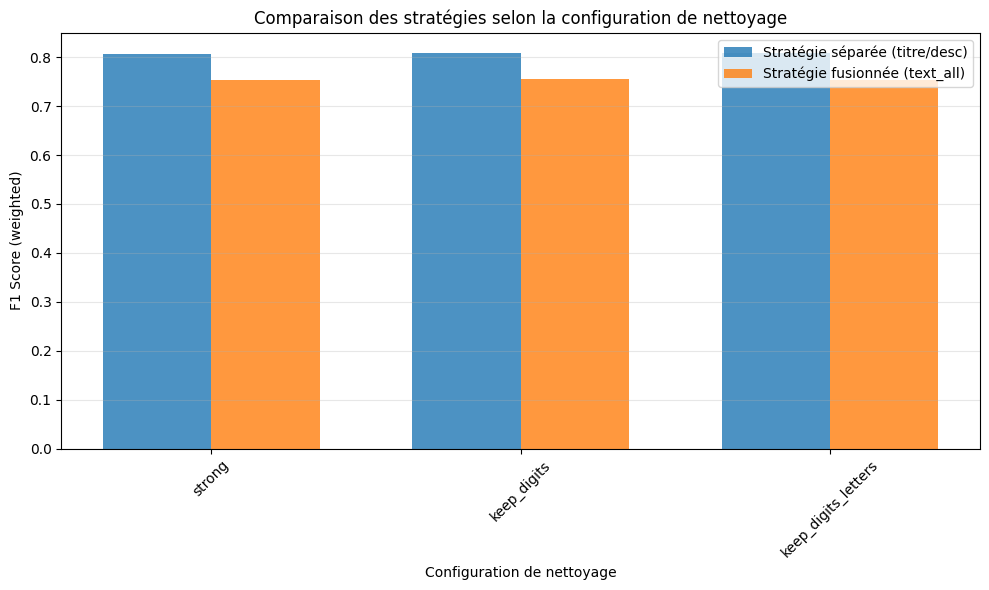

,cleaning_variant,remove_single_digit,remove_single_letter,f1_split,f1_merged,diff_split_minus_merged
0,strong,True,True,0.806993,0.752625,0.054368
1,keep_digits,False,True,0.809208,0.755571,0.053638
2,keep_digits_letters,False,False,0.809352,0.754022,0.055330


In [5]:
# ============================================================
# TABLEAU RÉCAPITULATIF DES RÉSULTATS
# ============================================================

results_df = pd.DataFrame(results_list)

print("\n" + "=" * 70)
print("TABLEAU COMPARATIF : IMPACT DU NETTOYAGE SUR LES PERFORMANCES")
print("=" * 70)
print()
print(results_df.to_string(index=False))
print()

# Trouver la meilleure configuration
best_split = results_df.loc[results_df["f1_split"].idxmax()]
best_merged = results_df.loc[results_df["f1_merged"].idxmax()]

print("=" * 70)
print("MEILLEURES CONFIGURATIONS :")
print("=" * 70)
print(f"\nStratégie SÉPARÉE (titre/description) :")
print(f"  Configuration : {best_split['cleaning_variant']}")
print(f"  F1 Score      : {best_split['f1_split']:.4f}")

print(f"\nStratégie FUSIONNÉE (text_all) :")
print(f"  Configuration : {best_merged['cleaning_variant']}")
print(f"  F1 Score      : {best_merged['f1_merged']:.4f}")
print()

# Affichage graphique si matplotlib disponible
try:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = range(len(results_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], results_df["f1_split"], 
           width, label="Stratégie séparée (titre/desc)", alpha=0.8)
    ax.bar([i + width/2 for i in x], results_df["f1_merged"], 
           width, label="Stratégie fusionnée (text_all)", alpha=0.8)
    
    ax.set_xlabel("Configuration de nettoyage")
    ax.set_ylabel("F1 Score (weighted)")
    ax.set_title("Comparaison des stratégies selon la configuration de nettoyage")
    ax.set_xticks(x)
    ax.set_xticklabels(results_df["cleaning_variant"], rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
except ImportError:
    print("(matplotlib non disponible, graphique ignoré)")

results_df

- <h2>Construction des Pipelines Comparatifs</h2>